In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import tqdm
import yaml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from train_trafo import build_dataset_for_gridpoints, SpectraCosmoDataset, _normalize
from first_tranformer_test import Transformer

In [2]:
model_name = "all_gps_shuffled_test"  # set this variable to the model to visualize

In [3]:
weights_path = f"model_states/train_{model_name}/finished_model_weights.pt"
train_loss_path = f"loss_files/{model_name}_train_eval_loss.csv"

with open(f"log_files/{model_name}_config.yaml") as f:
    params = yaml.safe_load(f)

suite_to_use = params['suite_to_use']
suite_of_spectra = params['suite_of_spectra']
batch_size = params['batch_size']
n_epochs = params['n_epochs']
learning_rate = params['learning_rate']

d_model = params['model']['d_model']
num_heads = params['model']['num_heads']
num_layers = params['model']['num_layers']
d_ff = params['model']['d_ff']
dropout = params['model']['dropout']

## Training loss curve

In [4]:
tain_eval_loss = []
with open(train_loss_path, "r") as file:
    reader = csv.reader(file)
    loss_plot = [i for i in reader][1:]

train_loss, eval_loss = [list(map(float, col)) for col in zip(*loss_plot)]

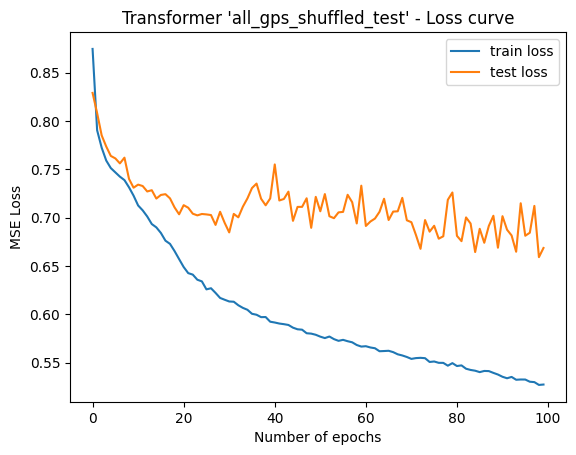

In [5]:
plt.plot([i for i in range(len(train_loss))], train_loss, label="train loss")
plt.plot([i for i in range(len(eval_loss))], eval_loss, label="test loss")

plt.ylabel("MSE Loss")
plt.xlabel("Number of epochs")
plt.legend()
plt.title(f"Transformer '{model_name}' - Loss curve")

plt.savefig(f"plots/{model_name}_losscurve.pdf", format="PDF")
# plt.show()

## Inference

### Build dataset

In [6]:
################# Make random list of gridpoints for train, eval and test sets #################
index_list = np.array(list(range(50)))
np.random.seed(42)
np.random.shuffle(index_list)

n_train = int(0.7 * len(index_list))
n_eval  = int(0.15 * len(index_list))

train_gps = index_list[:n_train]
eval_gps  = index_list[n_train:n_train + n_eval]
test_gps  = index_list[n_train + n_eval:]

################ Make the datasets #####################

X_train, y_train = build_dataset_for_gridpoints(train_gps, suite_to_use, suite_of_spectra)
X_eval,  y_eval  = build_dataset_for_gridpoints(eval_gps,  suite_to_use, suite_of_spectra)
X_test,  y_test  = build_dataset_for_gridpoints(test_gps,  suite_to_use, suite_of_spectra)

train_dataset = SpectraCosmoDataset(X_train, y_train)
eval_dataset  = SpectraCosmoDataset(X_eval,  y_eval)
test_dataset  = SpectraCosmoDataset(X_test,  y_test)

############### Standardize the data ####################

X_mean = train_dataset.X.mean(dim=0)
X_std  = train_dataset.X.std(dim=0) + 1e-8

y_mean = train_dataset.y.mean(dim=0)
y_std  = train_dataset.y.std(dim=0) + 1e-8

_normalize(train_dataset, X_mean, X_std, y_mean, y_std)
_normalize(eval_dataset, X_mean, X_std, y_mean, y_std)
_normalize(test_dataset, X_mean, X_std, y_mean, y_std)

############## Test if there is no information leakege between datasets ##############

train_cosmo = set(map(tuple, y_train))
test_cosmo  = set(map(tuple, y_test))

assert train_cosmo.isdisjoint(test_cosmo)

############# Make dataloaders ################

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
eval_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)


In [7]:
gps_list = [i for i in range(50)]

X_all, y_all = build_dataset_for_gridpoints(gps_list, suite_to_use, suite_of_spectra)

print(X_all.shape[0])

index_list = np.array(list(range(X_all.shape[0])))
np.random.seed(42)
np.random.shuffle(index_list)

X_all = X_all[index_list]
y_all = y_all[index_list]

n_train = int(0.7 * X_all.shape[0])
n_eval  = int(0.15 * X_all.shape[0])

print(n_train, n_eval)

X_train, y_train = X_all[:n_train], y_all[:n_train]
X_eval,  y_eval = X_all[n_train:n_eval+n_train], y_all[n_train:n_eval+n_train]
X_test,  y_test = X_all[n_eval+n_train:], y_all[n_eval+n_train:]

train_dataset = SpectraCosmoDataset(X_train, y_train)
eval_dataset  = SpectraCosmoDataset(X_eval,  y_eval)
test_dataset  = SpectraCosmoDataset(X_test,  y_test)

X_mean = train_dataset.X.mean(dim=0)
X_std  = train_dataset.X.std(dim=0) + 1e-8

y_mean = train_dataset.y.mean(dim=0)
y_std  = train_dataset.y.std(dim=0) + 1e-8

_normalize(train_dataset, X_mean, X_std, y_mean, y_std)
_normalize(eval_dataset, X_mean, X_std, y_mean, y_std)
_normalize(test_dataset, X_mean, X_std, y_mean, y_std)

50000
35000 7500


### Initialize Transformer

In [8]:
len_spectra = train_dataset.X.shape[1]
len_output = train_dataset.y.shape[1]

device = torch.device("cpu")

model = Transformer(len_spectra, len_output, d_model, num_heads, num_layers, d_ff, dropout)

state_dict = torch.load(weights_path, map_location=device)
model.load_state_dict(state_dict)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(model)

Transformer(
  (encoder_embedding): SpectraTokenEmbedding(
    (proj): Linear(in_features=1, out_features=32, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (encoding_layers): ModuleList(
    (0-1): 2 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=32, out_features=32, bias=True)
        (W_k): Linear(in_features=32, out_features=32, bias=True)
        (W_v): Linear(in_features=32, out_features=32, bias=True)
        (W_o): Linear(in_features=32, out_features=32, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=32, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=32, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
  )
  (fc): Linear(in_features=32, out_features=4, bias=T

In [9]:
def eval_model(model, loader, criterion, device):
    all_preds = []
    all_targets = []
    model.eval()

    total_loss = []
    with torch.no_grad():
        for X, y in tqdm.tqdm(loader):
            X = X.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            y_pred = model(X)
            loss = criterion(y_pred, y)

            total_loss.append(loss.item())

            all_preds.append(y_pred)
            all_targets.append(y)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)
    
    avarage_loss = np.array(total_loss).mean()
    return avarage_loss, all_targets, all_preds

### Run the model test loop

In [18]:
test_loss, y_test_true, y_test_pred = eval_model(model, test_loader, criterion, device)

print(f"Test MSE: {test_loss:.2e}")

  0%|          | 0/63 [00:00<?, ?it/s]/u/jerbo/CLIMB-Project/env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 63/63 [00:43<00:00,  1.46it/s]

Test MSE: 4.63e-01


In [19]:
# undo the normalization
y_test_true, y_test_pred  = y_test_true*y_std + y_mean, y_test_pred*y_std + y_mean
y_true, y_pred = y_test_true.numpy(), y_test_pred.numpy()

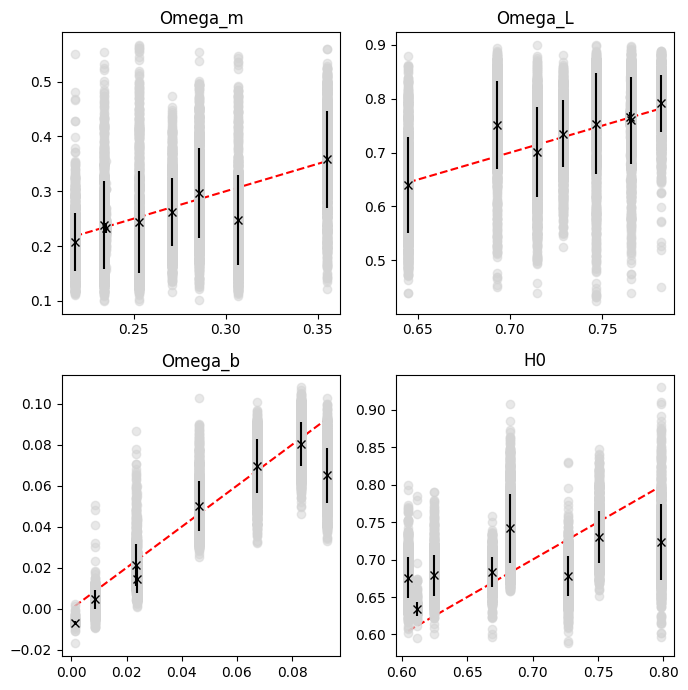

In [27]:
params = ["Omega_m", "Omega_b", "Omega_L", "H0"]

y_true_by_param = [y_true[:, i] for i in range(len(params))]
y_pred_by_param = [y_pred[:, i] for i in range(len(params))]

fig, axs = plt.subplots(2, 2, figsize=(7, 7))

for index in range(4):

    y_true_par = y_true_by_param[index]
    y_pred_par = y_pred_by_param[index]

    y_pred_mean_par = []
    y_pred_std_par = []
    y_true_unique_par = []
    y_pred_per_unique_value = []
    for true_value in set(y_true_par):
        y_pred_this_true_value = y_pred_par[y_true_par == true_value]
        mean_this_true_value = y_pred_this_true_value.mean()
        std_this_true_value = y_pred_this_true_value.std()

        y_pred_std_par.append(std_this_true_value)
        y_pred_mean_par.append(mean_this_true_value)
        y_true_unique_par.append(true_value)

        y_pred_per_unique_value.append(y_pred_this_true_value)

    ax = axs[index%2, index//2]

    ax.plot(sorted(y_true_par), sorted(y_true_par), linestyle="--", c="red", zorder=1)

    ax.scatter(y_true_par, y_pred_par, alpha=0.5, c="lightgrey", zorder=2)
    ax.errorbar(y_true_unique_par, y_pred_mean_par, yerr=y_pred_std_par, linestyle="None", marker="x", color="black", zorder=3)
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]+y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    #plt.scatter(y_true_unique_Om, [y_pred_mean_Om[i]-y_pred_std_Om[i] for i in range(len(y_true_unique_Om))], linestyle="None", marker="o", color="red")
    
    ax.set_title(f"{params[index]}")
    #ax.set_xticks(sorted(y_true_unique_par))
    #ax.set_xticklabels([f"{x:.2f}" for x in y_true_unique_par])

plt.tight_layout()
plt.savefig(f"plots/{model_name}_inference.pdf", format="PDF")


In [13]:
print("TRAIN")
print("means: ", [y_train[:, i].mean() for i in range(4)])
print("max:", [y_train[:, i].max() for i in range(4)])
print("min:", [y_train[:, i].min() for i in range(4)])
print("EVAL")
print("means: ", [y_eval[:, i].mean() for i in range(4)])
print("max:", [y_eval[:, i].max() for i in range(4)])
print("min:", [y_eval[:, i].min() for i in range(4)])

TRAIN
means:  [0.29586326, 0.04955222571428571, 0.70413674, 0.6998015085714285]
max: [0.4929, 0.0965, 0.8848, 0.8442]
min: [0.1152, 0.0012, 0.5071, 0.5516]
EVAL
means:  [0.29591306666666667, 0.049526879999999995, 0.7040869333333334, 0.6991240133333333]
max: [0.4929, 0.0965, 0.8848, 0.8442]
min: [0.1152, 0.0012, 0.5071, 0.5516]


In [14]:
state_dict = torch.load(weights_path, map_location="cpu")

for k in state_dict.keys():
    print(k)

encoder_embedding.proj.weight
encoder_embedding.proj.bias
positional_encoding.pe
encoding_layers.0.self_attn.W_q.weight
encoding_layers.0.self_attn.W_q.bias
encoding_layers.0.self_attn.W_k.weight
encoding_layers.0.self_attn.W_k.bias
encoding_layers.0.self_attn.W_v.weight
encoding_layers.0.self_attn.W_v.bias
encoding_layers.0.self_attn.W_o.weight
encoding_layers.0.self_attn.W_o.bias
encoding_layers.0.feed_forward.fc1.weight
encoding_layers.0.feed_forward.fc1.bias
encoding_layers.0.feed_forward.fc2.weight
encoding_layers.0.feed_forward.fc2.bias
encoding_layers.0.norm1.weight
encoding_layers.0.norm1.bias
encoding_layers.0.norm2.weight
encoding_layers.0.norm2.bias
encoding_layers.1.self_attn.W_q.weight
encoding_layers.1.self_attn.W_q.bias
encoding_layers.1.self_attn.W_k.weight
encoding_layers.1.self_attn.W_k.bias
encoding_layers.1.self_attn.W_v.weight
encoding_layers.1.self_attn.W_v.bias
encoding_layers.1.self_attn.W_o.weight
encoding_layers.1.self_attn.W_o.bias
encoding_layers.1.feed_forw

In [15]:
X_train[0].shape

(464,)

In [25]:
import math

layer_num = 0
d_k = d_model // num_heads

W_q = nn.Linear(d_model, d_model, bias=True)
W_k = nn.Linear(d_model, d_model, bias=True)
W_v = nn.Linear(d_model, d_model, bias=True)
W_o = nn.Linear(d_model, d_model, bias=True)

W_q.weight.data.copy_(state_dict[f"encoding_layers.{layer_num}.self_attn.W_q.weight"])
W_q.bias.data.copy_(state_dict[f"encoding_layers.{layer_num}.self_attn.W_q.bias"])
W_k.weight.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_k.weight"]
)
W_k.bias.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_k.bias"]
)
W_v.weight.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_v.weight"]
)
W_v.bias.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_v.bias"]
)
W_o.weight.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_o.weight"]
)
W_o.bias.data.copy_(
    state_dict[f"encoding_layers.{layer_num}.self_attn.W_o.bias"]
)

mock_input = torch.Tensor(X_train[1]) # torch.ones(1, 464)
proj = nn.Linear(1, d_model)
mock_input = proj(mock_input.unsqueeze(-1))

Q = W_q(mock_input).view(1, 464, num_heads, d_k).transpose(2, 1)
K = W_k(mock_input).view(1, 464, num_heads, d_k).transpose(2, 1)
V = W_v(mock_input).view(1, 464, num_heads, d_k).transpose(2, 1)

attn_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

# Softmax is applied to obtain attention probabilities
attn_probs = torch.softmax(attn_score, dim=-1)

# Multiply by values to obtain the final output
output = torch.matmul(attn_probs, V)

print(output.shape)

torch.Size([1, 4, 464, 8])


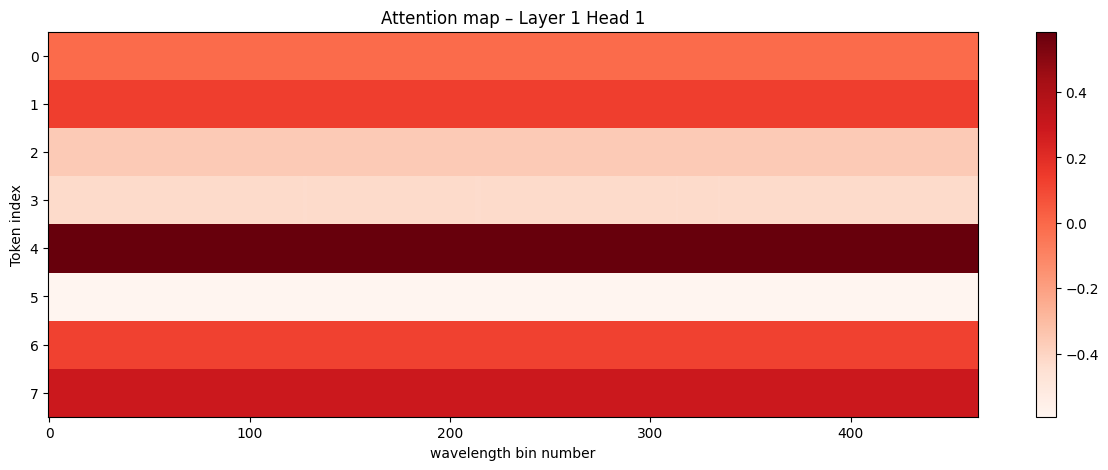

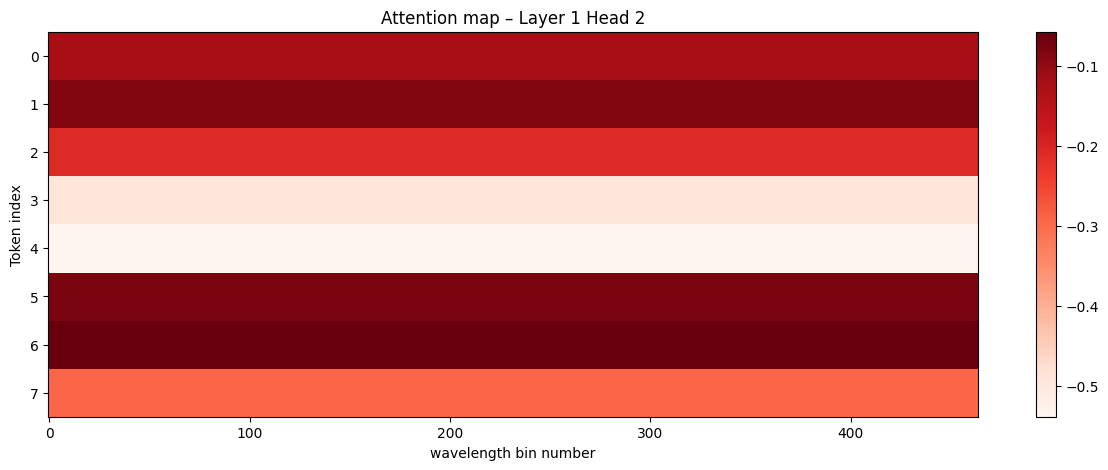

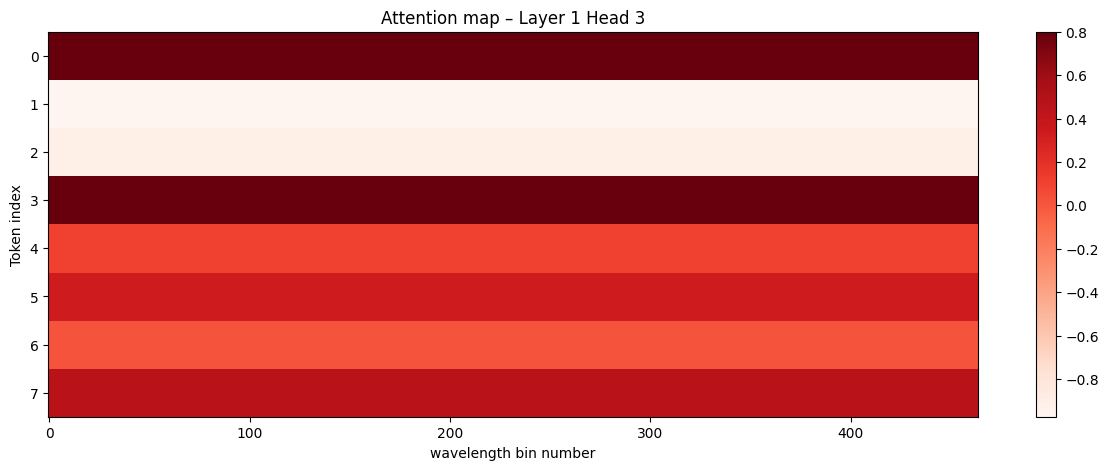

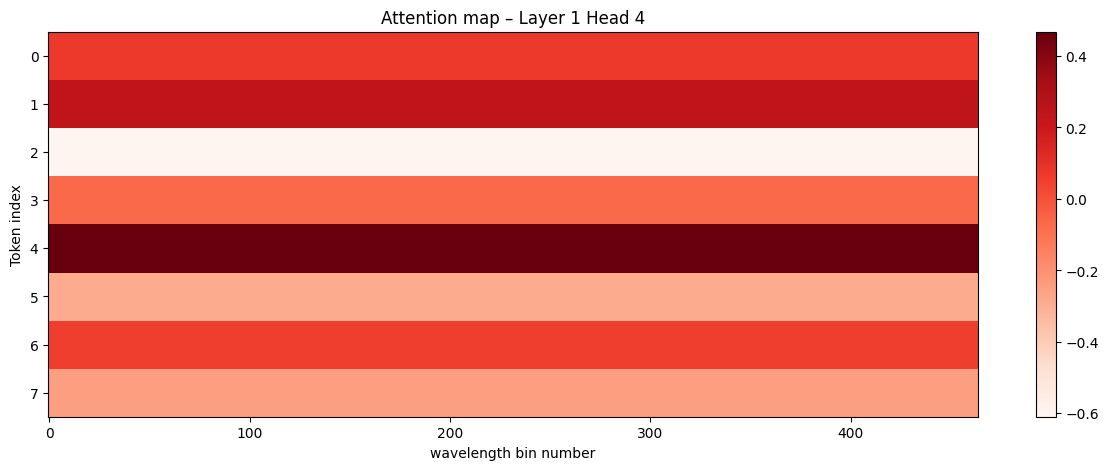

In [26]:
for h in range(num_heads):
    output_layer = output[0, h]
    fig = plt.subplots(figsize=(15, 5))
    plt.imshow(output_layer.T.detach().numpy(),interpolation="none", aspect="auto", cmap="Reds")
    plt.colorbar()
    plt.title(f"Attention map – Layer {layer_num+1} Head {h+1}")
    plt.xlabel("wavelength bin number")
    plt.ylabel("Token index")
    plt.show()